We use parallel tempering to observe the phase transition in the 2D ferromagnetic Ising model (1000 steps).

In [1]:
import os
os.chdir('../')
os.environ["TORCH_CUDA_ARCH_LIST"] = "8.0"  # A100

import torch
import numpy as np
import networkx as nx
from math import log10, ceil
from random import randint

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
from tqdm import tqdm

from src.tempering.temperer import Temperer
from src.utils import J2Q, coloring

In [2]:
device = torch.device("cuda")
dtype = torch.float16

ured = (0.86, 0.08, 0.24)
ublue = (0.12, 0.56, 1.0)

In [3]:
"""
W: number of systems (different J matrices)
L: number of temperature levels
K: number of parallel copies per temperature
N: number of variables
"""
n1, n2 = 100, 100
W, L, K, N, d, nsteps = 20, 15, 100, n1*n2, 4, 1000
beta = torch.logspace(log10(0.1), log10(0.7), steps=L, device=device) # (L,)

In [4]:
AM = torch.tensor(nx.to_numpy_array(nx.grid_2d_graph(n1, n2)), device=device, dtype=torch.bool)[None]
Q = J2Q(-AM[0].to(dtype))[None]

In [5]:
CIDX = coloring(AM.to_sparse_coo().cpu())

100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


In [6]:
print(f"Coloring in at most {max(CIDX.keys())+1} colors found.")

Coloring in at most 2 colors found.


In [7]:
pt = Temperer(N, K, Q, beta, CIDX=CIDX, device=device, dtype=dtype)
# warm up
pt.step_colored()
E = pt.exchange()

In [8]:
Es = torch.zeros((nsteps, W, L, K), dtype=dtype)
for i in tqdm(range(nsteps), bar_format='{l_bar}{bar:20}{r_bar}{bar:-10b}'):
    pt.step_colored()
    torch.cuda.synchronize()
    E = pt.exchange()
    Es[i] = E

100%|████████████████████| 1000/1000 [00:08<00:00, 115.60it/s]


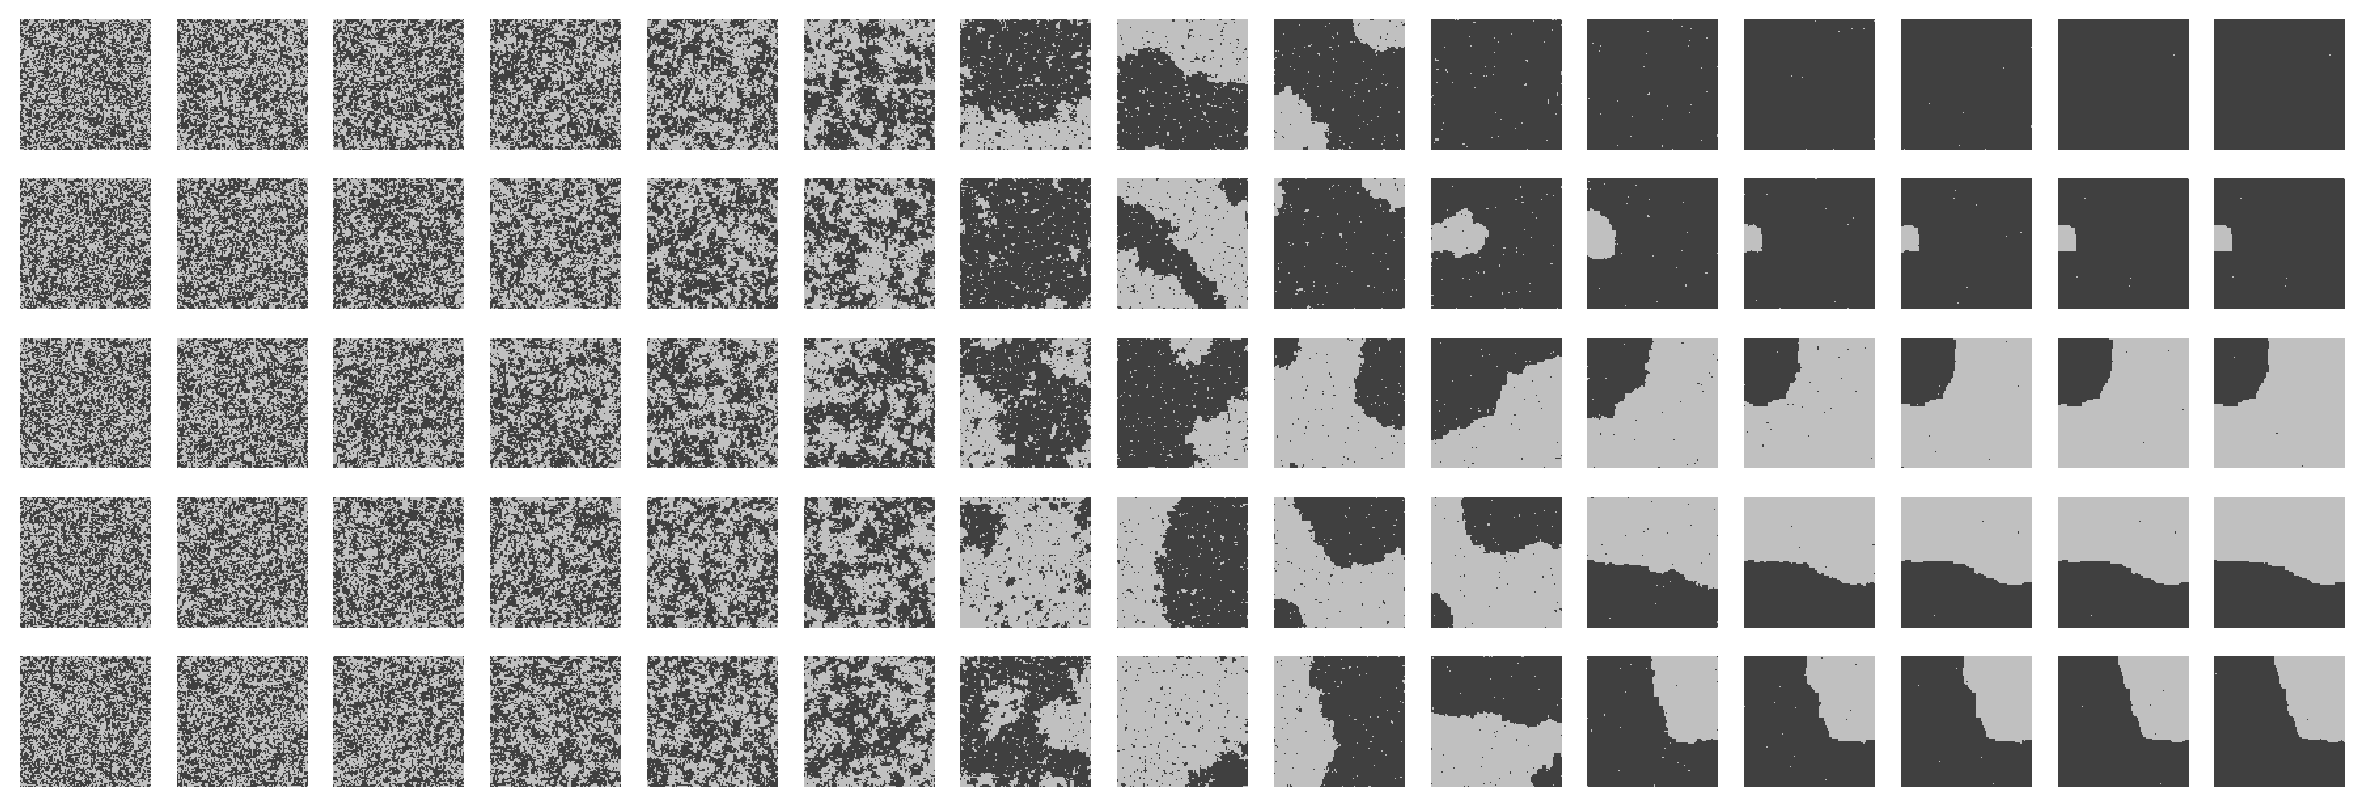

In [9]:
k = 5
fig, axs = plt.subplots(k, L, figsize=(L, k), dpi=200)
for i in range(L):
    for j in range(k):
        axs[j, i].matshow(pt.states[0, i, j].reshape(n1, n2).cpu().numpy(), vmin=-1/2, vmax=3/2, cmap='gray')
        axs[j, i].axis('off')
plt.show()

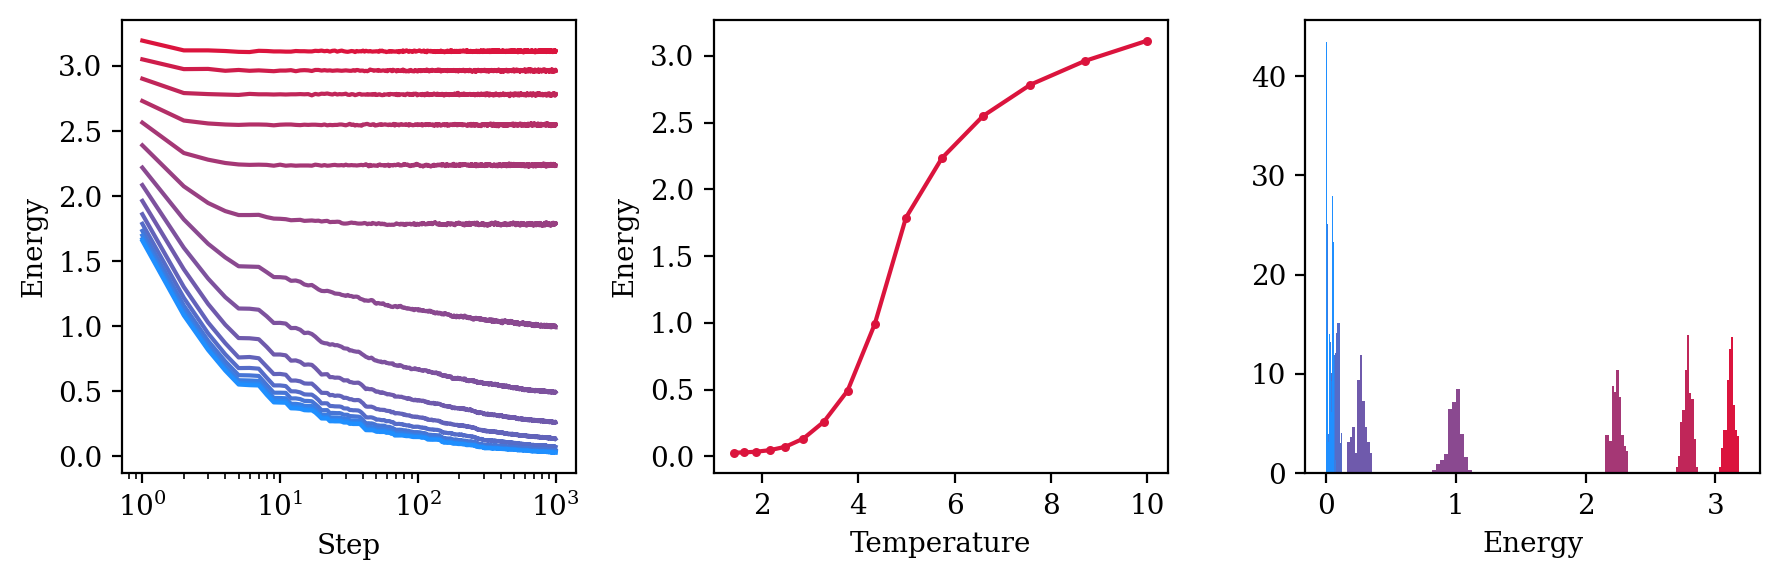

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3), dpi=200)

x = np.arange(nsteps) + 1
for i in range(L):
    c = i/(L-1)
    color = tuple(c * np.array(ublue) + (1 - c) * np.array(ured))
    y = Es[:, :, i].mean(dim=(1,-1)).cpu().numpy() / N
    ax1.plot(x, y, color=color)
ax1.set_xlabel('Step')
ax1.set_ylabel('Energy')
ax1.set_xscale('log')

x = beta
y = Es[-1, :, :].mean(dim=(0,2)) / N
x, y = x.cpu().numpy(), y.cpu().numpy()
ax2.plot(1/x, y, color=ured)
ax2.scatter(1/x, y, color=ured, s=5)
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Energy')
# ax2.set_xscale('log')

for i in range(0, L, 2):
    c = i/(L-1)
    color = tuple(c * np.array(ublue) + (1 - c) * np.array(ured))
    ax3.hist(Es[-1, :, i].flatten().numpy() / N, color=color, density=True)
ax3.set_xlabel('Energy')

plt.tight_layout()
plt.show()